**1. Exploratory data analysis**

In [1]:
#Import Tools for project
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("/content/creditcard.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

**Handling Missing Values**

In [4]:
df.isnull().values.any()

False

In [5]:
df.dropna()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


**Outlier Treatment**

Outlier treatment is unecessary for this dataset, since the raw dataset is already PCA transformed. Therefore, we can assume that the outlier values are already taken care of during the transformation.

From the raw dataset, Time is given as a timestamp. There the value is convert to local data and extract the hours in the attempt to identify if if the hour of the transaction is correlated with the likelability that the transaction is fraudulent

In [6]:
from datetime import datetime
df["Hour"] = df["Time"].apply(datetime.fromtimestamp).dt.hour

**Remove duplicates**

In [7]:
df.shape

(284807, 32)

In [8]:
duplicateRowsDf = df[df.duplicated()]
df.drop_duplicates(inplace= True)
df.shape

(283726, 32)

There was a total of 1081 duplication transaction in the data set

In [9]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.impute import MissingIndicator, SimpleImputer
from sklearn.preprocessing import  PolynomialFeatures, KBinsDiscretizer, FunctionTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, LabelBinarizer, OrdinalEncoder
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
from sklearn.linear_model import LogisticRegression, LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor,RandomForestClassifier,RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier,GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor 
from sklearn.svm import LinearSVC, LinearSVR, SVC, SVR
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import QuantileTransformer

# **Train-Test Split**

Before attempting Feature Engineering, we need to create another set to prevent it from leaking our information to the test set. 
Training Size will be 70% and Testing Size will be 30%

Time column will be dropped since hour will be used for the modeling

In [10]:
df = df.drop("Time", axis = 1)
df = df.drop("Hour", axis = 1)

**Feature Selection**

In [11]:
estimators=[ 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
X = df[estimators]
y = df['Class']
col = X.columns[:-1]
col

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21',
       'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28'],
      dtype='object')

In [12]:
import statsmodels.api as sm
X= sm.add_constant(X)
reg_logit = sm.Logit(y,X)
result_logit = reg_logit.fit()

Optimization terminated successfully.
         Current function value: 0.003927
         Iterations 13


In [13]:
result_logit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:               283726
Model:                          Logit   Df Residuals:                   283696
Method:                           MLE   Df Model:                           29
Date:                Sat, 27 Nov 2021   Pseudo R-squ.:                  0.6815
Time:                        18:37:51   Log-Likelihood:                -1114.1
converged:                       True   LL-Null:                       -3498.2
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7313      0.152    -57.566      0.000      -9.029      -8.434
V1             0.0842      0.041      2.029      0.042       0.003       0.166
V2             0.0142      0.058      0.244      0.807      -0.099       0.128
V3             0.0371      0.046      0.814      0.416      -0.052       0.126
V4             0.7085      0.074      9.606      0.000       0.564       0.853
V5             0.1034      0.066      1.576      0.115      -0.025       0.232
V6            -0.1269      0.076     -1.664      0.096      -0.276       0.023
V7            -0.1085      0.066     -1.640      0.101      -0.238       0.021
V8            -0.1713      0.031     -5.578      0.000      -0.231      -0.111
V9            -0.2598      0.110     -2.370      0.018      -0.475      -0.045
V10           -0.8242      0.097     -8.501      0.000      -1.014      -0.634
V11           -0.0090      0.076     -0.118      0.906      -0.158       0.140
V12            0.0625      0.086      0.725      0.468      -0.106       0.231
V13           -0.3147      0.081     -3.868      0.000      -0.474      -0.155
V14           -0.5361      0.062     -8.684      0.000      -0.657      -0.415
V15           -0.0922      0.084     -1.095      0.274      -0.257       0.073
V16           -0.2018      0.125     -1.616      0.106      -0.447       0.043
V17            0.0097      0.069      0.142      0.887      -0.125       0.145
V18           -0.0375      0.128     -0.294      0.769      -0.288       0.213
V19            0.0795      0.096      0.828      0.408      -0.109       0.268
V20           -0.4510      0.081     -5.541      0.000      -0.611      -0.291
V21            0.3730      0.058      6.416      0.000       0.259       0.487
V22            0.5874      0.129      4.566      0.000       0.335       0.840
V23           -0.0975      0.058     -1.681      0.093      -0.211       0.016
V24            0.1278      0.149      0.856      0.392      -0.165       0.421
V25           -0.0180      0.131     -0.137      0.891      -0.275       0.239
V26           -0.0131      0.190     -0.069      0.945      -0.385       0.359
V27           -0.8134      0.122     -6.658      0.000      -1.053      -0.574
V28           -0.2979      0.089     -3.343      0.001      -0.473      -0.123
Amount         0.0009      0.000      2.465      0.014       0.000       0.002
==============================================================================

Possibly complete quasi-separation: A fraction 0.31 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

The result in the graph above illustrates that some of the values have a higher preferred alpha (5%) and therefore which shows that is low signficant relationship to the variable. Therefore backward elmination is used to remove the highest Pvalue.

In [14]:
def back_feature_elem (data_frame,dep_var,col_list):
    """ Takes in the dataframe, the dependent variable and a list of column names, runs the regression repeatedly eleminating feature with the highest
    P-value above alpha one at a time and returns the regression summary with all p-values below alpha"""

    while len(col_list)>0 :
        model=sm.Logit(dep_var,data_frame[col_list])
        result=model.fit(disp=0)
        largest_pvalue=round(result.pvalues,3).nlargest(1)
        if largest_pvalue[0]<(0.0001):
            return result
            break
        else:
            col_list=col_list.drop(largest_pvalue.index)

result=back_feature_elem(X,df.Class,col)

In [15]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Class   No. Observations:               283726
Model:                          Logit   Df Residuals:                   283698
Method:                           MLE   Df Model:                           27
Date:                Sat, 27 Nov 2021   Pseudo R-squ.:                    -inf
Time:                        18:37:54   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                       -3498.2
Covariance Type:            nonrobust   LLR p-value:                     1.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
V1            -3.8503      0.012   -314.625      0.000      -3.874      -3.826
V2             3.8048      0.012    310.135      0.000       3.781       3.829
V3            -8.5616      0.027   -319.025      0.000      -8.614      -8.509
V4             5.0462      0.016    313.283      0.000       5.015       5.078
V5            -5.9105      0.019   -314.060      0.000      -5.947      -5.874
V6            -2.0187      0.007   -271.803      0.000      -2.033      -2.004
V7           -11.1402      0.035   -318.515      0.000     -11.209     -11.072
V8             2.6585      0.009    284.651      0.000       2.640       2.677
V9            -5.4890      0.018   -309.594      0.000      -5.524      -5.454
V10          -12.7321      0.040   -318.828      0.000     -12.810     -12.654
V11            8.9049      0.028    316.080      0.000       8.850       8.960
V12          -16.0526      0.050   -319.507      0.000     -16.151     -15.954
V13            0.1949      0.005     37.561      0.000       0.185       0.205
V14          -16.6006      0.052   -319.557      0.000     -16.702     -16.499
V15           -0.3622      0.006    -63.189      0.000      -0.373      -0.351
V16          -15.1065      0.047   -318.684      0.000     -15.199     -15.014
V17          -27.3943      0.086   -320.370      0.000     -27.562     -27.227
V18          -10.1986      0.032   -315.451      0.000     -10.262     -10.135
V19            3.3170      0.012    273.860      0.000       3.293       3.341
V20            2.0012      0.009    210.708      0.000       1.983       2.020
V21            2.2942      0.010    231.734      0.000       2.275       2.314
V22            0.1861      0.007     25.998      0.000       0.172       0.200
V23           -0.2017      0.009    -21.842      0.000      -0.220      -0.184
V24           -0.1602      0.008    -18.862      0.000      -0.177      -0.144
V25            0.6242      0.011     59.429      0.000       0.604       0.645
V26            0.2029      0.011     18.870      0.000       0.182       0.224
V27            2.5322      0.016    156.071      0.000       2.500       2.564
V28            1.1545      0.016     74.214      0.000       1.124       1.185
==============================================================================
"""

In [16]:
new_features=df[['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V20','V21', 'V22', 'V23', 'V25', 'V26', 'V27', 'V28', 'Amount','Class']]
X=new_features.iloc[:,:-1]
y=new_features.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size =0.3, shuffle = True,random_state=20)

In [17]:
#let's take a look at the shape
X_train.shape, y_train.shape
X_test.shape, y_train.shape

((85118, 26), (198608,))

**Feature Scaling**

Since most of the data has already been scaled through PCA. The only attribute left to normalize is Amount.

In [18]:
from sklearn.preprocessing import RobustScaler
robust_scaler = RobustScaler()
X_train['Amount'] = robust_scaler.fit_transform(X_train[['Amount']])

In [19]:
X_train.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V20,V21,V22,V23,V25,V26,V27,V28,Amount
216663,-5.142081,-0.267300,-1.512484,0.265863,0.750518,-1.357756,0.046396,0.593253,-0.411269,-0.584126,0.855954,0.848802,0.719329,-0.375491,0.502761,0.882405,0.566781,-2.244864,-0.296695,0.870256,0.367210,1.422690,0.149724,-0.298291,-0.413652,0.236703
170949,2.059784,-0.833726,-1.215540,-0.791726,-0.657099,-1.347547,-0.120323,-0.460362,-0.634271,0.743484,-0.427063,0.020007,1.021732,-0.158342,-0.019366,0.845768,0.201847,0.171724,-0.000397,-0.162081,0.218779,-0.211276,-0.440611,-0.042894,-0.040684,0.967975
89079,1.228178,-0.666980,0.486390,-0.605313,-1.218074,-0.819493,-0.478723,-0.110390,-1.123775,0.818951,1.408241,0.621671,0.227253,0.302984,0.260584,-1.033617,-0.249890,-0.355927,-0.389769,-0.821856,0.107980,0.018900,0.868009,-0.068902,0.012743,0.566695
279454,2.124143,-0.023915,-1.600832,0.207131,0.286987,-0.978375,0.233258,-0.354333,0.665464,0.020922,-1.336828,-0.004838,0.046277,0.473940,0.806312,-0.008668,-0.746140,-0.234079,0.197535,0.737547,-0.083127,0.356031,-0.067229,-0.021259,-0.066090,-0.295739
165037,1.924922,-1.909699,-1.633719,-1.603169,-1.074742,-0.687381,-0.604737,-0.311698,-1.802489,1.757954,0.423697,-0.356569,0.578481,0.053185,-0.436557,-0.226768,-0.032576,0.010244,0.231051,0.663167,-0.184756,0.038188,0.064946,-0.052759,-0.038660,2.763854


# **Checking the Skewness**

In [20]:
#Looking at the columns for the trainset
cols = X_train.columns
cols

Index(['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11',
       'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V20', 'V21', 'V22', 'V23',
       'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

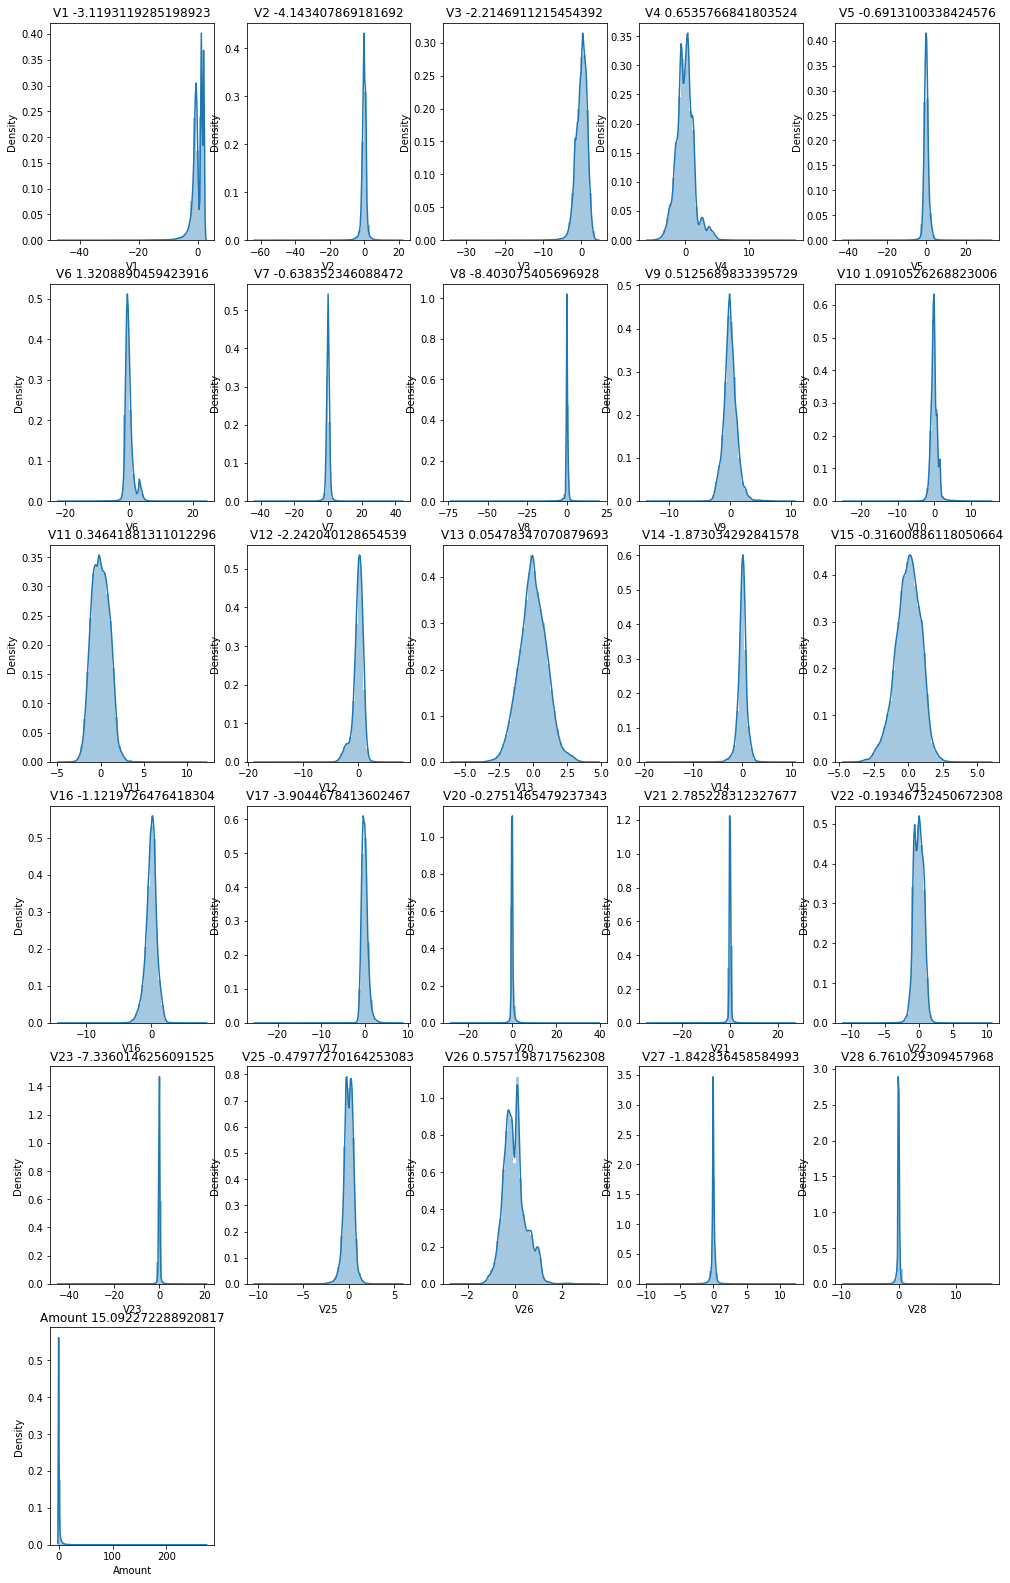

In [21]:
#Plotting a distribution for the variable to determine the skewness of each variable.
k=0
plt.figure(figsize=(17,28))
for col in cols :    
    k=k+1
    plt.subplot(6, 5,k)    
    sns.distplot(X_train[col])
    plt.title(col+' '+str(X_train[col].skew()))

From the graph, we noticed that alot of variables are heavily skewed. Therefore, we will only for particular varibles for a normal distribution

**Mitigate skweness with PowerTransformer**

In [22]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'yeo-johnson', standardize = True, copy = False)
X_train[cols] = pt.fit_transform(X_train)

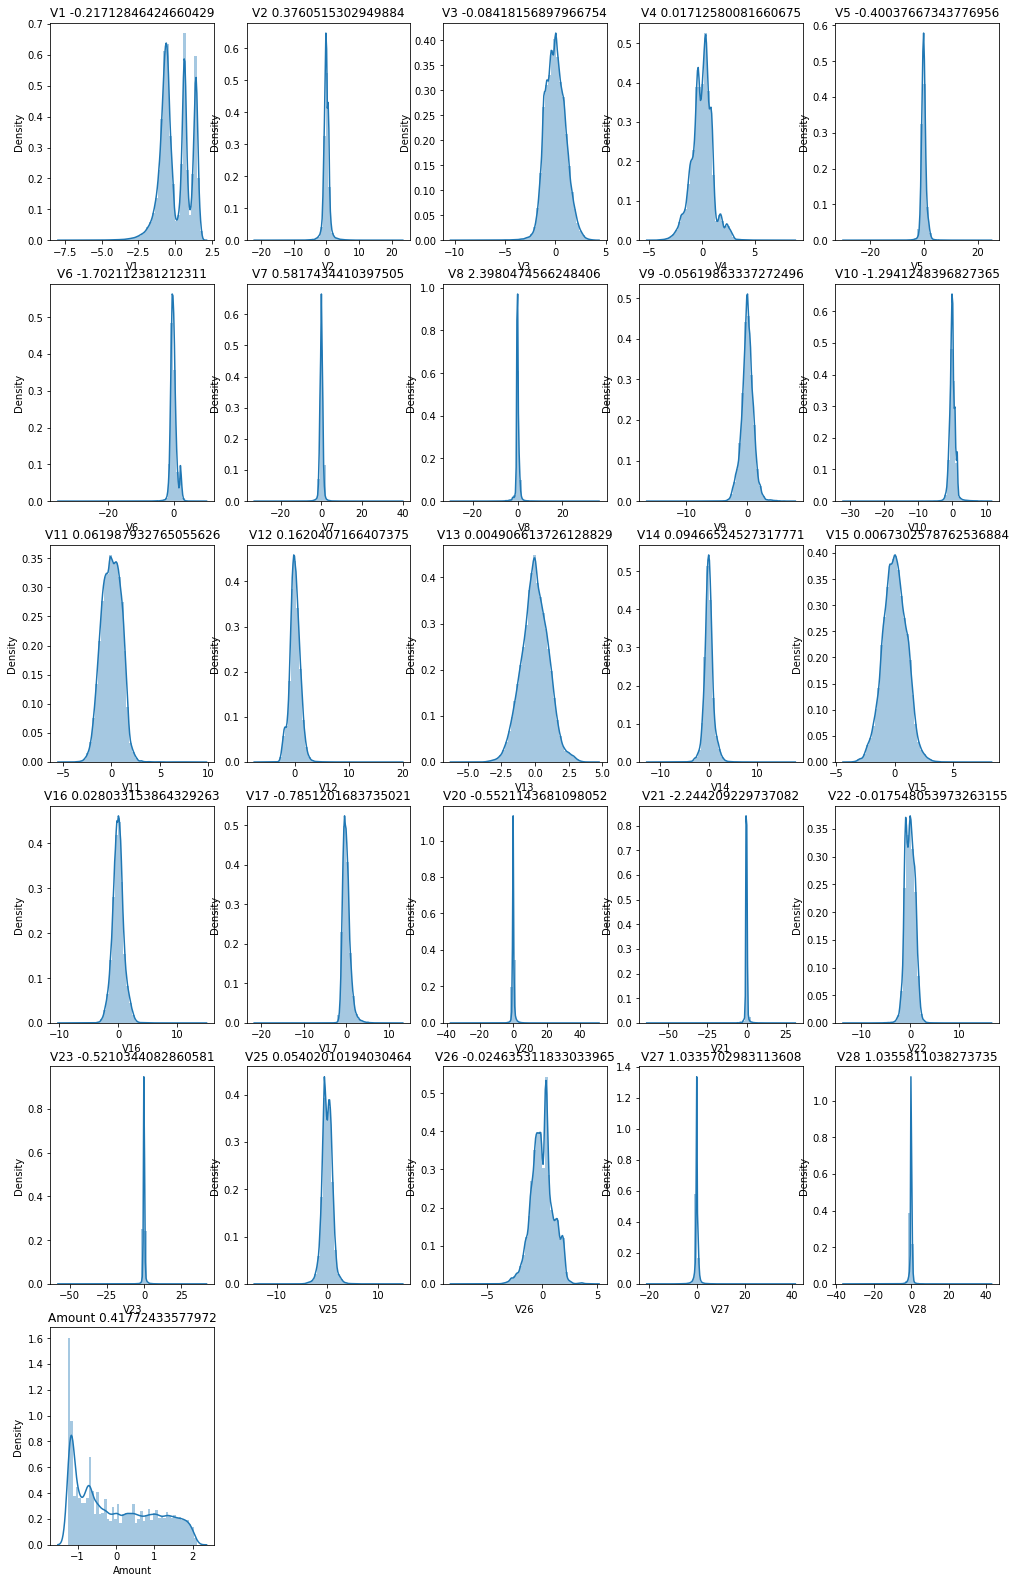

In [23]:
k=0
plt.figure(figsize=(17,28))
for col in cols :    
    k=k+1
    plt.subplot(6, 5,k)    
    sns.distplot(X_train[col])
    plt.title(col+' '+str(X_train[col].skew()))

After the transformation, the variables are more normally distributed and more stablize.

**Oversampling**

In [24]:
#Importing undersampler form library
from imblearn.over_sampling import  RandomOverSampler
from collections import Counter

In [25]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

In [26]:
# Befor sampling class distribution
print('Before sampling class distribution:-',Counter(y_train))
# new class distribution 
print('New class distribution:-',Counter(y_resampled))

Before sampling class distribution:- Counter({0: 198274, 1: 334})
New class distribution:- Counter({0: 198274, 1: 198274})


# **Model Building for balanced data with Oversampling**

The cross varlidation strategy for each model will be 5 folds.

In [27]:
#Import Metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

#Import for cross validation

# Importing libraries for cross validation
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

*Decision Tree*

In [28]:
param_grid1 = {
    'max_depth': range(4,8,12),
    'min_samples_leaf': range(50,150,50),
    'min_samples_split': range(50,150,50),
}

dt = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator= dt, param_grid= param_grid1, scoring= 'roc_auc', cv =5,verbose =1)

In [29]:
grid_search.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(4, 8, 12),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [30]:
#cv results
cv_result = pd.DataFrame(grid_search.cv_results_)
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.217098,0.072267,0.026320,0.000570,4,50,50,"{'max_depth': 4, 'min_samples_leaf': 50, 'min_...",0.975664,0.975735,0.975531,0.976082,0.975194,0.975641,0.000288,1
1,3.173021,0.025090,0.027124,0.001616,4,50,100,"{'max_depth': 4, 'min_samples_leaf': 50, 'min_...",0.975664,0.975735,0.975531,0.976082,0.975194,0.975641,0.000288,1
2,3.159259,0.042073,0.026933,0.001728,4,100,50,"{'max_depth': 4, 'min_samples_leaf': 100, 'min...",0.975664,0.975735,0.975531,0.976082,0.975194,0.975641,0.000288,1
3,3.194845,0.026238,0.026346,0.000321,4,100,100,"{'max_depth': 4, 'min_samples_leaf': 100, 'min...",0.975664,0.975735,0.975531,0.976082,0.975194,0.975641,0.000288,1


In [31]:
#Printing the optimal sensitivity score and hyperparameters
print('Best roc_auc: -', grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc_auc: - 0.9756411963737728
DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, min_samples_split=50)


In [32]:
#Buliding the model with the best hyperparameters
dt_model = DecisionTreeClassifier(criterion= 'gini', random_state= 20, max_depth= 4, min_samples_leaf = 50, min_samples_split= 50)

dt_model.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=50, min_samples_split=50,
                       random_state=20)

*Prediction on the test set*

In [33]:
#Predict Probability
dt_pred = dt_model.predict(X_test)

In [34]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#Classification Report
print(classification_report(y_test,dt_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     84979
           1       0.04      0.90      0.07       139

    accuracy                           0.96     85118
   macro avg       0.52      0.93      0.53     85118
weighted avg       1.00      0.96      0.98     85118



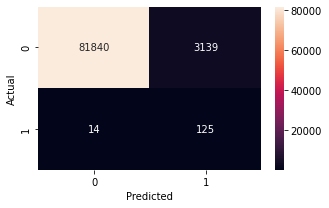

In [35]:
#Confusion Matrix
cm = confusion_matrix(y_test, dt_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index= np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(5,3))
sns.heatmap(cm, fmt = 'g', annot= True)

In [36]:
confusion = metrics.confusion_matrix(y_test, dt_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, dt_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9629573063276863
Sensitivity:- 0.8992805755395683
Specificity:- 0.9630614622436131


In [37]:
from sklearn.model_selection import cross_val_score
#Cross Validare Score
dt_scores = cross_val_score(dt_model, X_resampled, y_resampled, cv = 5)

print("Decision Tree Cross Validate Score:", np.round(dt_scores.mean()*100,3), '%')

Decision Tree Cross Validate Score: 95.974 %


*Plotting ROC*

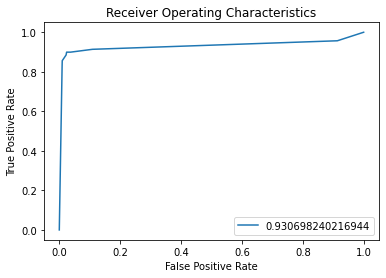

In [38]:
dt_proba = dt_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, dt_proba)
auc = metrics.roc_auc_score(y_test, dt_proba)

plt.title('Receiver Operating Characteristics')
plt.plot(fpr, tpr, label = str(auc))
plt.legend(loc = 4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

*Precision-Recall Curve*

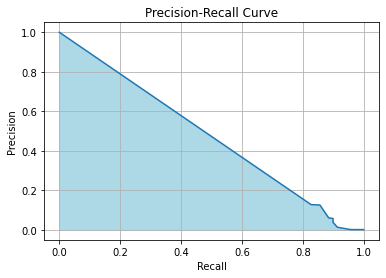

In [39]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, dt_proba)
fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title("Precision-Recall Curve")
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.fill_between(recall, precision, color = 'lightblue')
plt.grid()
plt.show()

*Logisitic Regression*

In [40]:
from sklearn.linear_model import LogisticRegression

#Creating KFold object with 5 split
folds = KFold(n_splits=5, shuffle = True, random_state = 20)

#Specify params
params3 = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_log = GridSearchCV(estimator = LogisticRegression(),
                         param_grid = params3,
                         scoring = 'roc_auc',
                         cv = folds,
                         verbose = 1,
                         return_train_score = True)
#Fit the model
model_log.fit(X_resampled, y_resampled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=20, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [41]:
#Logisitics Regression results
log_results = pd.DataFrame(model_log.cv_results_)
log_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.110958,0.063654,0.038326,0.000769,0.01,{'C': 0.01},0.986179,0.986066,0.986371,0.985790,0.985674,0.986016,0.000254,6,0.986006,0.985991,0.985981,0.986012,0.986158,0.986030,0.000065
1,2.158955,0.092498,0.038186,0.001019,0.1,{'C': 0.1},0.986219,0.986077,0.986406,0.985823,0.985709,0.986047,0.000254,5,0.986036,0.986013,0.986013,0.986045,0.986184,0.986058,0.000064
2,2.149052,0.029432,0.040072,0.002190,1,{'C': 1},0.986222,0.986077,0.986408,0.985822,0.985711,0.986048,0.000255,1,0.986039,0.986014,0.986015,0.986049,0.986184,0.986060,0.000063
3,2.199671,0.045855,0.039047,0.000228,10,{'C': 10},0.986222,0.986077,0.986408,0.985823,0.985710,0.986048,0.000255,3,0.986039,0.986015,0.986015,0.986049,0.986184,0.986060,0.000063
4,2.182698,0.051694,0.038840,0.000953,100,{'C': 100},0.986221,0.986077,0.986408,0.985823,0.985710,0.986048,0.000255,2,0.986039,0.986015,0.986015,0.986049,0.986184,0.986060,0.000063
5,2.196103,0.045799,0.039061,0.000597,1000,{'C': 1000},0.986221,0.986076,0.986408,0.985823,0.985710,0.986048,0.000255,4,0.986039,0.986015,0.986015,0.986049,0.986184,0.986060,0.000063


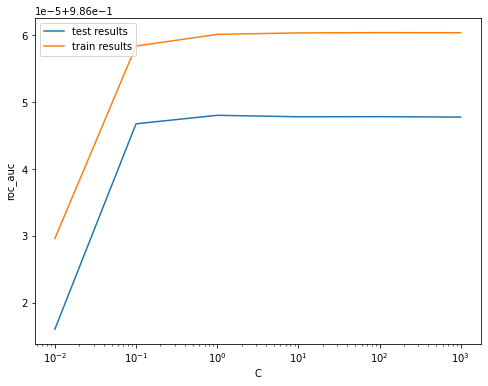

In [42]:
#plot of C versus train and validation score
plt.figure(figsize=(8,6))
plt.plot(log_results['param_C'], log_results['mean_test_score'])
plt.plot(log_results['param_C'],log_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('roc_auc')
plt.legend(['test results','train results'], loc = 'upper left')
plt.xscale('log')

In [43]:
#Best roc_auc with best c
best_score = model_log.best_score_
best_C = model_log.best_params_['C']

print("The highest test roc auc is", best_score, "at C =", best_C)

The highest test roc auc is 0.9860480534975992 at C = 1


In [44]:
#Logistic Regression with the best C

log_imb = LogisticRegression(C= 1, random_state= 20, penalty= 'l2')

In [45]:
log_tree_model = log_imb.fit(X_resampled, y_resampled)

*Prediction on test set*

In [46]:
#Prediction on test set
log_pred = log_tree_model.predict(X_test)

In [47]:
#Classification Report
print(classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77     84979
           1       0.00      0.96      0.01       139

    accuracy                           0.62     85118
   macro avg       0.50      0.79      0.39     85118
weighted avg       1.00      0.62      0.76     85118



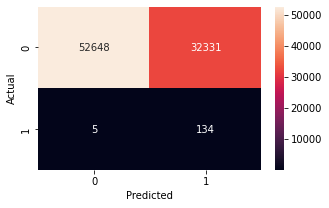

In [48]:
#Confusion Matrix
cm = confusion_matrix(y_test, log_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index= np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize=(5,3))
sns.heatmap(cm, fmt = 'g', annot= True)

In [49]:
log_confusion = metrics.confusion_matrix(y_test, log_pred)
TP = log_confusion[1,1] # true positive 
TN = log_confusion[0,0] # true negatives
FP = log_confusion[0,1] # false positives
FN = log_confusion[1,0] # false negatives

In [50]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, log_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.6201038558236801
Sensitivity:- 0.9640287769784173
Specificity:- 0.6195412984384377


In [51]:
#Cross Validate Score
from sklearn.model_selection import cross_val_score
logreg_scores = cross_val_score(log_tree_model, X_resampled, y_resampled, cv = 5)

print("Logisitic Regression Cross Validate Score:", np.round(logreg_scores.mean()*100,3), '%')

Logisitic Regression Cross Validate Score: 93.995 %


Plotting ROC

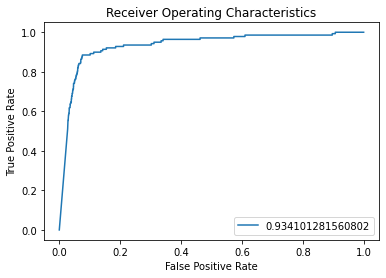

In [52]:
log_proba = log_tree_model.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, log_proba)
auc = metrics.roc_auc_score(y_test, log_proba)

plt.title('Receiver Operating Characteristics')
plt.plot(fpr, tpr, label = str(auc))
plt.legend(loc = 4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Plotting Precision Recall Curve

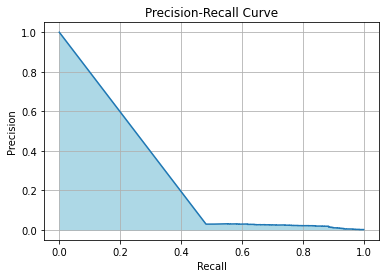

In [53]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, log_proba)
fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title("Precision-Recall Curve")
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.fill_between(recall, precision, color = 'lightblue')
plt.grid()
plt.show()

*XGBoost*

In [54]:
from xgboost import XGBClassifier

Tuning the hyperparameters for XGBoost

In [55]:
#creating a KFold

folds = 5

#specifying the range of the hyperparameters

param_grid2 = {'learning_rate' : [0.2, 0.6],
               'subsample': [0.2, 0.4, 0.6]}

#Specifying the model
xgb_model = XGBClassifier(max_depth= 4, n_estimators= 100, random_state= 20)

model_xgb = GridSearchCV(estimator= xgb_model, param_grid= param_grid2, scoring= 'roc_auc', cv= folds, verbose= 1, return_train_score= True)

model_xgb.fit(X_resampled,y_resampled)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5, estimator=XGBClassifier(max_depth=4, random_state=20),
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.2, 0.4, 0.6]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [56]:
#XGBoost Results
xgb_results = pd.DataFrame(model_xgb.cv_results_)
xgb_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,50.739218,0.299453,0.353504,0.007980,0.2,0.2,"{'learning_rate': 0.2, 'subsample': 0.2}",0.999946,0.999985,0.999997,0.999969,0.999931,0.999966,0.000024,6,0.999985,0.999979,0.999982,0.999990,0.999986,0.999984,3.822208e-06
1,61.924812,0.393167,0.348370,0.006247,0.2,0.4,"{'learning_rate': 0.2, 'subsample': 0.4}",0.999953,0.999996,0.999995,0.999970,0.999954,0.999974,0.000019,4,0.999993,0.999992,0.999987,0.999986,0.999992,0.999990,2.922655e-06
2,68.036527,0.449420,0.342876,0.011497,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.999961,0.999995,0.999998,0.999961,0.999942,0.999972,0.000022,5,0.999997,0.999992,0.999987,0.999991,0.999993,0.999992,3.195048e-06
3,48.658656,0.187308,0.346452,0.005454,0.6,0.2,"{'learning_rate': 0.6, 'subsample': 0.2}",0.999973,1.000000,1.000000,0.999995,0.999966,0.999987,0.000014,3,0.999999,1.000000,1.000000,0.999998,0.999999,0.999999,6.474223e-07
4,59.707934,0.153191,0.351802,0.009184,0.6,0.4,"{'learning_rate': 0.6, 'subsample': 0.4}",0.999964,1.000000,1.000000,0.999993,0.999990,0.999989,0.000013,1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.965068e-17
5,66.184233,0.374618,0.359923,0.006907,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.999973,1.000000,1.000000,0.999995,0.999977,0.999989,0.000012,2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000e+00


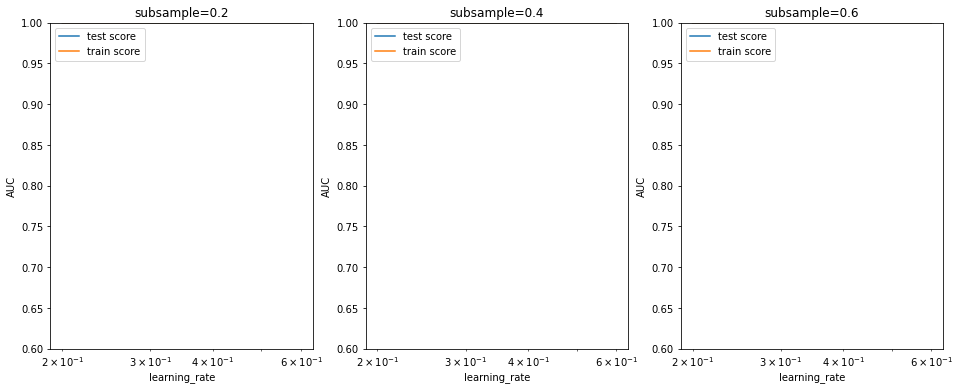

In [57]:
plt.figure(figsize= (16,6))

param_grid3 = {'learning_rate' : [0.2, 0.6],
               'subsample': [0.2, 0.4, 0.6]}

for n , subsample in enumerate (param_grid3['subsample']):
  
  plt.subplot(1,len(param_grid3['subsample']), n+1)
  df = xgb_results[xgb_results['param_subsample']==subsample]
  
  plt.plot(df["param_learning_rate"], df["mean_test_score"])
  plt.plot(df["param_learning_rate"], df["mean_train_score"])
  plt.xlabel('learning_rate')
  plt.ylabel('AUC')
  plt.title("subsample={0}".format(subsample))
  plt.ylim([0.60, 1])
  plt.legend(['test score', 'train score'], loc='upper left')
  plt.xscale('log')

Model with best hyperparameters

From the graph above, we noticed that the train score is almost close to 1 and we noticed that amongest the hyperparameter, the best results are learning_rate: 0.6 and subsample 0.6.

In [58]:
model_xgb.best_params_

{'learning_rate': 0.6, 'subsample': 0.4}

In [59]:
params1 = {'learning_rate': 0.6,
          'max_depth': 4, 
          'n_estimators':100,
          'subsample':0.4,
          'random state' : 20,
         'objective':'binary:logistic'}

xgb_imb = XGBClassifier(params = params1)
xgb_imb.fit(X_resampled, y_resampled)

XGBClassifier(params={'learning_rate': 0.6, 'max_depth': 4, 'n_estimators': 100,
                      'objective': 'binary:logistic', 'random state': 20,
                      'subsample': 0.4})

*Prediction on test set*

In [60]:
#Prediction on test set
xgb_pred = xgb_imb.predict(X_test)

In [61]:
#Classification Report
print(classification_report(y_test, xgb_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     84979
           1       0.15      0.90      0.25       139

    accuracy                           0.99     85118
   macro avg       0.57      0.95      0.62     85118
weighted avg       1.00      0.99      0.99     85118



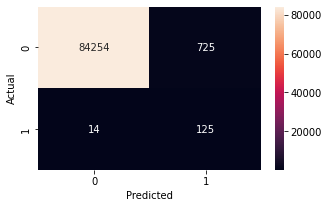

In [62]:
#Confusion Matrix
cm = confusion_matrix(y_test, xgb_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index=np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (5,3))
sns.heatmap(cm, fmt='g', annot = True)

In [63]:
xgb_confusion = metrics.confusion_matrix(y_test, xgb_pred)
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [64]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, xgb_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9913179351018586
Sensitivity:- 0.8992805755395683
Specificity:- 0.9630614622436131


In [65]:
#Predicted Probability
xgb_proba = xgb_imb.predict_proba(X_test)[:,1]

Plotting ROC

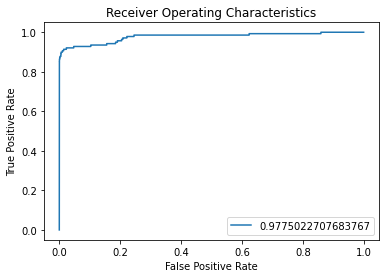

In [66]:
#Plotting ROC Curve
fpr, tpr, _ = metrics.roc_curve(y_test, xgb_proba)
auc = metrics.roc_auc_score(y_test, xgb_proba)

plt.title('Receiver Operating Characteristics')
plt.plot(fpr, tpr, label = str(auc))
plt.legend(loc = 4)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Plotting Preicison-Recall Curve

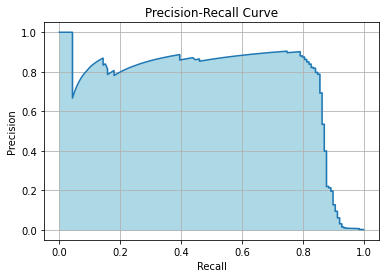

In [67]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, xgb_proba)
fig, ax = plt.subplots()
ax.plot(recall, precision)

ax.set_title("Precision-Recall Curve")
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')
ax.fill_between(recall, precision, color = 'lightblue')
plt.grid()
plt.show()